In [1]:
import os
from pathlib import Path
import random
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio
from torch.utils.data import Dataset, DataLoader, TensorDataset
import glob
from utils import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
data_dir = 'data/audio_speech_actors_01-24/'

In [3]:
output_path = data_dir 
feature_path = output_path + 'features'
audio_path = output_path + 'audio_clips'
model_path = output_path +'model'

In [4]:
os.makedirs(feature_path, exist_ok=True)
os.makedirs(audio_path, exist_ok=True)

In [5]:
def get_log_melspec(data, sample_rate):
  """
  Function for extracting features from an audio sample.  The audio is preprocess to remove silence and then
  padded on both sides to ensure each clip is 5 seconds.
  Then the log mel spectrogram is extracted.
  """
  trimmed, _ = librosa.effects.trim(data, top_db=55)
  padded = np.pad(trimmed, (int(sample_rate*2.5-len(trimmed)//2), int(sample_rate*2.5-len(trimmed)//2)), 'constant')
  mel = librosa.feature.melspectrogram(y=padded, sr=sample_rate, n_fft=1024, win_length=480, hop_length=512, n_mels=128)
  return librosa.power_to_db(mel, ref=np.max)

In [6]:
LABEL_DICT = {0:'neutral', 1:'calm', 2:'happy', 3:'sad', 4:'angry', 5:'fear', 6:'disgust', 7:'surprise'}
LABELS = list(LABEL_DICT.values())

In [7]:
LABELS

['neutral', 'calm', 'happy', 'sad', 'angry', 'fear', 'disgust', 'surprise']

In [8]:
data = dict(
    actor = [],
    emotion = [],
    intensity = [],
    gender = [],
    path = []
)

wav_files = glob.glob(data_dir+'/**/*.wav', recursive=True)

for wav in wav_files:
    wav = Path(wav)  # Convert string to Path object
    _, _, emo, emo_int, _, _, actor = wav.stem.split('-')

    data['actor'].append(int(actor))
    data['emotion'].append(int(emo)-1)
    data['intensity'].append(int(emo_int))
    data['gender'].append('male' if int(actor) % 2 == 0 else 'female')
    data['path'].append(str(wav))

df_rav = pd.DataFrame.from_dict(data)
df_rav['emotion_label'] = df_rav.emotion.replace(LABEL_DICT, inplace=False)

# extract features and save to dataframe
def load_melspec(row):
  a, sr = librosa.load(row['path'], sr=24000)
  return get_log_melspec(a, sr) # Seham check here the silence_thresh, silence_thresh=55

df_rav['feats'] = df_rav.apply(load_melspec, axis=1)

In [9]:
df_rav.head()

,actor,emotion,intensity,gender,path,emotion_label,feats
0,6,5,1,male,data/audio_speech_actors_01-24/Actor_06/03-01-...,fear,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8..."
1,6,6,2,male,data/audio_speech_actors_01-24/Actor_06/03-01-...,disgust,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8..."
2,6,3,1,male,data/audio_speech_actors_01-24/Actor_06/03-01-...,sad,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8..."
3,6,6,2,male,data/audio_speech_actors_01-24/Actor_06/03-01-...,disgust,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8..."
4,6,6,1,male,data/audio_speech_actors_01-24/Actor_06/03-01-...,disgust,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8..."


In [10]:
df_rav.to_pickle('data/Ravdess.pkl')

In [11]:
failed_files = df_rav[df_rav['feats'].isnull()]
print(f"Number of failed files: {len(failed_files)}")

Number of failed files: 0


In [12]:
df_rav['feats'][2].shape # 2D MAtrices represents Mel-Spectrogram

(128, 235)

In [13]:
# validate extracted features
for idx, row in df_rav.iterrows():
  assert row.feats.shape == (128, 235), f'shape: {row.feats.shape}'

In [14]:
df_rav.head()

,actor,emotion,intensity,gender,path,emotion_label,feats
0,6,5,1,male,data/audio_speech_actors_01-24/Actor_06/03-01-...,fear,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8..."
1,6,6,2,male,data/audio_speech_actors_01-24/Actor_06/03-01-...,disgust,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8..."
2,6,3,1,male,data/audio_speech_actors_01-24/Actor_06/03-01-...,sad,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8..."
3,6,6,2,male,data/audio_speech_actors_01-24/Actor_06/03-01-...,disgust,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8..."
4,6,6,1,male,data/audio_speech_actors_01-24/Actor_06/03-01-...,disgust,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8..."


In [15]:
df_rav.drop(columns=['intensity'], inplace=True)

In [16]:
df_rav

,actor,emotion,gender,path,emotion_label,feats
0,6,5,male,data/audio_speech_actors_01-24/Actor_06/03-01-...,fear,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8..."
1,6,6,male,data/audio_speech_actors_01-24/Actor_06/03-01-...,disgust,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8..."
2,6,3,male,data/audio_speech_actors_01-24/Actor_06/03-01-...,sad,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8..."
3,6,6,male,data/audio_speech_actors_01-24/Actor_06/03-01-...,disgust,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8..."
4,6,6,male,data/audio_speech_actors_01-24/Actor_06/03-01-...,disgust,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8..."
...,...,...,...,...,...,...
1435,19,7,female,data/audio_speech_actors_01-24/Actor_19/03-01-...,surprise,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8..."
1436,19,5,female,data/audio_speech_actors_01-24/Actor_19/03-01-...,fear,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8..."
1437,19,6,female,data/audio_speech_actors_01-24/Actor_19/03-01-...,disgust,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8..."
1438,19,5,female,data/audio_speech_actors_01-24/Actor_19/03-01-...,fear,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8..."


In [17]:
df_rav.to_pickle("Ravdess.pkl")

In [20]:
# split dataset by actors
'''
all_actors = df_rav['actor'].unique()
actors_gender = df_rav.groupby('actor')['gender'].unique().reset_index()

train_actors, tmp = train_test_split(actors_gender, train_size=19, stratify=actors_gender['gender'], random_state=36851234)
val_actors, test_actors = train_test_split(tmp, train_size=3, stratify=tmp['gender'], random_state=36851234)

train_actors = train_actors['actor'].tolist()
val_actors = val_actors['actor'].tolist()
test_actors = test_actors['actor'].tolist()

train_actors, val_actors, test_actors
'''

"\nall_actors = df_rav['actor'].unique()\nactors_gender = df_rav.groupby('actor')['gender'].unique().reset_index()\n\ntrain_actors, tmp = train_test_split(actors_gender, train_size=19, stratify=actors_gender['gender'], random_state=36851234)\nval_actors, test_actors = train_test_split(tmp, train_size=3, stratify=tmp['gender'], random_state=36851234)\n\ntrain_actors = train_actors['actor'].tolist()\nval_actors = val_actors['actor'].tolist()\ntest_actors = test_actors['actor'].tolist()\n\ntrain_actors, val_actors, test_actors\n"

In [30]:
# To load the best model:
model = ResNet(len(LABELS))
model.load_state_dict(torch.load(ckpt_path, map_location='cpu'))
model.to(device);

In [31]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    preds = []
    probs = []
    with torch.no_grad():  # Disable gradient calculation
        for data in dataloader:
            if len(data) == 3:
                inputs, labels, _ = data
            else:
                inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track loss and accuracy
            running_loss += loss.item()
            prop_dist = torch.nn.Softmax(dim=-1)(outputs)
            prob, predicted = prop_dist.max(1)
            
            preds.extend(predicted.cpu().numpy())
            probs.extend(prob.cpu().numpy())
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / len(dataloader)
    accuracy = correct / total

    print(f"Evaluation Loss: {avg_loss:.4f}, Evaluation Accuracy: {accuracy:.4f}")
    return avg_loss, accuracy, preds, probs

In [32]:
evaluate_model(model, dl_train, criterion, device)
evaluate_model(model, dl_val, criterion, device)
_, _, test_preds, test_probs = evaluate_model(model, dl_test, criterion, device)

Evaluation Loss: 2.8920, Evaluation Accuracy: 0.3220
Evaluation Loss: 3.0499, Evaluation Accuracy: 0.3264
Evaluation Loss: 3.2119, Evaluation Accuracy: 0.2569


# _________________________________________________________________

In [19]:
from sklearn.model_selection import train_test_split
X= df_rav.iloc[:, 1:].values
Y = df_rav['emotion'].values
x_train_v, x_test, y_train_v, y_test = train_test_split(X, Y, random_state=42,test_size=0.1, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(X, Y, random_state=42,test_size=0.1, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((1296, 5), (1296,), (144, 5), (144,), (144, 5), (144,))

In [20]:
'''df_train = df_rav[df_rav.actor.isin(train_actors)]
df_val = df_rav[df_rav.actor.isin(val_actors)]
df_test = df_rav[df_rav.actor.isin(test_actors)]

df_train.shape, df_val.shape, df_test.shape'''

'df_train = df_rav[df_rav.actor.isin(train_actors)]\ndf_val = df_rav[df_rav.actor.isin(val_actors)]\ndf_test = df_rav[df_rav.actor.isin(test_actors)]\n\ndf_train.shape, df_val.shape, df_test.shape'

In [21]:
Audio(data_dir + 'Actor_01/03-01-01-01-01-01-01.wav')

### Data Loader

In [108]:
class getdata(Dataset):
    def __init__(self, data, labels, transform=None):
        """
        Args:
            data (list of tuples): Each element is a tuple (file_path, spectrogram_array).
            labels (list): List of integer labels corresponding to the data.
        """
        self.data = data
        self.labels = labels
        self.transform = transform
        print(type(self.data[0]), self.data[0])


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        #spectrogram = self.data[idx]  # Discard file_path
        #label = self.labels[idx]
        entry = self.data[idx]
        label = int(entry[0])  # assuming integer class label is at index 0
        spectrogram = np.array(entry[4], dtype=np.float32) 

        #spectrogram = np.array(spectrogram, dtype=np.float32)
        #spectrogram = torch.tensor(spectrogram).unsqueeze(0)


        # Ensure spectrogram is a float32 tensor
        spectrogram = torch.tensor(spectrogram, dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(label, dtype=torch.long)

        if self.transform:
            spectrogram = self.transform(spectrogram)

        return spectrogram, label

In [109]:
ds_train = getdata(x_train, y_train)
ds_test = getdata(x_test, y_test)
ds_val = getdata(x_val, y_val)

dl_train = DataLoader(ds_train, batch_size=12, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=12, shuffle=False)
dl_val = DataLoader(ds_val, batch_size=12, shuffle=False)

<class 'numpy.ndarray'> [4 'male'
 'data/audio_speech_actors_01-24/Actor_06/03-01-05-02-01-02-06.wav'
 'angry' array([[-80., -80., -80., ..., -80., -80., -80.],
                [-80., -80., -80., ..., -80., -80., -80.],
                [-80., -80., -80., ..., -80., -80., -80.],
                ...,
                [-80., -80., -80., ..., -80., -80., -80.],
                [-80., -80., -80., ..., -80., -80., -80.],
                [-80., -80., -80., ..., -80., -80., -80.]], dtype=float32)]
<class 'numpy.ndarray'> [7 'female'
 'data/audio_speech_actors_01-24/Actor_03/03-01-08-01-01-01-03.wav'
 'surprise'
 array([[-80., -80., -80., ..., -80., -80., -80.],
        [-80., -80., -80., ..., -80., -80., -80.],
        [-80., -80., -80., ..., -80., -80., -80.],
        ...,
        [-80., -80., -80., ..., -80., -80., -80.],
        [-80., -80., -80., ..., -80., -80., -80.],
        [-80., -80., -80., ..., -80., -80., -80.]], dtype=float32)]
<class 'numpy.ndarray'> [7 'female'
 'data/audio_speec

In [110]:
import math

def set_parameter_requires_grad(model, feature_extracting, trainable_layers):
    if feature_extracting:
        for name, param in model.named_parameters():
            print(name)
            if name not in trainable_layers:
                param.requires_grad = False

class ResNetBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False)
        self.shortcut = nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False) if in_ch != out_ch else None

        self.bn1 = nn.BatchNorm2d(out_ch)
        self.bn2 = nn.BatchNorm2d(out_ch)

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.shortcut:
            identity = self.shortcut(identity)
        out += identity
        return F.relu(out)

class ResNet(nn.Module):
    def __init__(self, class_num):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(32)

        self.layer1 = ResNetBlock(32, 64, stride=1)
        self.layer2 = ResNetBlock(64, 128, stride=2)

        # Increased dropout rate
        self.dropout = nn.Dropout(0.50)
        self.fc = nn.Linear(128, class_num)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size=3, stride=2, padding=1)

        x = self.layer1(x)
        x = self.layer2(x)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)

In [111]:
def load_resnet18_audio():
  model = ResNet(len(LABELS))

  return model

In [112]:
import os
import torch
import random
import numpy as np
from tqdm import tqdm

def set_seed(seed):
    """
    Sets random seeds for reproducibility.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def evaluate_model(model, dataloader, criterion, device):
    """
    Evaluates the model on a given dataloader.
    """
    model.eval()  # Set model to evaluation mode
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track loss and accuracy
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / len(dataloader)
    accuracy = correct / total

    return avg_loss, accuracy


def train_model(model, dl_train, dl_val, criterion, optimizer, scheduler, device, num_epochs=10, checkpoint_dir='checkpoint', save_best=True):
    """
    Trains the model with checkpointing and validation.
    """
    model.to(device)
    best_val_loss = float('inf')

    # Ensure checkpoint directory exists
    os.makedirs(checkpoint_dir, exist_ok=True)

    for epoch in range(num_epochs):
        #print(f"Epoch [{epoch+1}/{num_epochs}]")

        # Training phase
        model.train()
        running_train_loss, correct_train, total_train = 0.0, 0, 0

        for inputs, labels in tqdm(dl_train, desc="Training", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimization step

            # Track training loss and accuracy
            running_train_loss += loss.item()
            _, predicted = outputs.max(1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_loss = running_train_loss / len(dl_train)
        train_accuracy = correct_train / total_train

        # Validation phase
        val_loss, val_accuracy = evaluate_model(model, dl_val, criterion, device)

        # Step the learning rate scheduler
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_loss)
        else:
            scheduler.step()

        # Print epoch results
        #print(f"\tTrain Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        #print(f"\tValidation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Save best model
        if save_best and val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_path = os.path.join(checkpoint_dir, 'best_model_rav.pth')
            torch.save(model.state_dict(), best_model_path)
            #print(f"Best model saved with validation loss: {val_loss:.4f}")

    # Load the best model (if saved)
    if save_best:
        best_model_path = os.path.join(checkpoint_dir, 'best_model_rav.pth')
        model.load_state_dict(torch.load(best_model_path))

    return model, best_val_loss, val_accuracy


In [113]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
lr = 0.001

checkpoint_dir = 'checkpoint/'
os.makedirs(checkpoint_dir, exist_ok=True)  # Ensure directory exists
checkpoint_path = os.path.join(checkpoint_dir, 'best_model_rav.pth')


In [114]:
# Multi-run training and evaluation
n_runs = 3#3
n_epochs = 50#60
best_val_loss = float('inf')  # Initialize as infinity for comparison

# Loop through runs
for run in range(n_runs):
    run_seed = 42 + run  # Seed varies for each run
    set_seed(run_seed)  # Ensure reproducibility for each run

    #print(f"Run {run+1}/{n_runs}")
    #print("=" * 30)

    # Initialize model and optimizer
    model = load_resnet18_audio().to(device)

    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=lr,
        weight_decay=0.001,  # Regularization already in use
        amsgrad=True
    )

    # Scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.4, patience=4, verbose=True
    )
    # Train and validate
    model, val_loss, val_acc = train_model(
        model, dl_train, dl_val, criterion, optimizer, scheduler, device, num_epochs=n_epochs
    )

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        #print(f"New best model found in Run {run+1} with validation loss: {val_loss:.4f}")
        torch.save(model.state_dict(), checkpoint_path)

    print()  # Blank line for better readability between runs

# Load the best model after all runs
print("Loading the best model for final evaluation...")
model = load_resnet18_audio()
try:
    model.load_state_dict(torch.load(checkpoint_path))
    model.to(device)

    # Evaluate on validation data
    val_loss, val_acc = evaluate_model(model, dl_val, criterion, device=device)
    print(f"Training complete! Best Val Loss = {best_val_loss:.4f}, Best Val Accuracy = {val_acc:.4f}")
except FileNotFoundError:
    print("Error: Best model checkpoint not found. Ensure training was successful.")

print("-" * 30)


Loading the best model for final evaluation...
Training complete! Best Val Loss = 0.8869, Best Val Accuracy = 0.6736
------------------------------


In [115]:
# To load the best model:
model = load_resnet18_audio()
model.load_state_dict(torch.load(checkpoint_path ))
model.to('cuda')

ResNet(
  (conv1): Conv2d(1, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): ResNetBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (shortcut): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): ResNetBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (shortcut): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, af

In [116]:
train_loss, train_acc = evaluate_model(model, dl_train, criterion, device)
print(f"Test Loss = {train_loss:.4f}, train Accuracy = {train_acc:.4f}")

val_loss, val_acc = evaluate_model(model, dl_val, criterion, device)
print(f"Test Loss = {val_loss:.4f}, val Accuracy = {val_acc:.4f}")

test_loss, test_acc = evaluate_model(model, dl_test, criterion, device)
print(f"Test Loss = {test_loss:.4f}, Test Accuracy = {test_acc:.4f}")


Test Loss = 0.4217, train Accuracy = 0.9468
Test Loss = 0.9807, val Accuracy = 0.6736
Test Loss = 0.9807, Test Accuracy = 0.6736


In [117]:
import sys
sys.path.append('../../')

In [ ]:
from crp.crp.attribution import CondAttribution
from crp.concepts import ChannelConcept
from crp.helper import get_layer_names

from zennit.composites import EpsilonPlusFlat
from zennit.canonizers import SequentialMergeBatchNorm

from crp.visualization import FeatureVisualization
from crp.image import plot_grid, imgify

ModuleNotFoundError: No module named 'crp.concepts'

: 

In [ ]:
X = torch.tensor(audio_sample['feats']).unsqueeze(0).unsqueeze(0)
y = torch.tensor(audio_sample['emotion']).unsqueeze(0)

X.requires_grad = True

X.shape, y.shape, y

(torch.Size([1, 1, 128, 235]), torch.Size([1]), tensor([4]))

In [ ]:
softmax = torch.nn.Softmax(dim=-1)
def select_max(pred):
    id = softmax(pred).argmax(-1).item()
    print(f"wrt. class {id}")
    mask = torch.zeros_like(pred)
    mask[0, id] = pred[0, id]
    return mask

In [ ]:
layer_name = 'conv1'

# define LRP rules and canonizers in zennit
composite = EpsilonPlusFlat([SequentialMergeBatchNorm()])

# load CRP toolbox
attribution = CondAttribution(model)

# here, each channel is defined as a concept
# or define your own notion!
cc = ChannelConcept()

# get layer names of Conv2D and MLP layers
layer_names = get_layer_names(model, [nn.Conv2d, nn.Linear])

# get a conditional attribution for output 4 (angry)
conditions = [{'y': [4]}]

X = X.to(device)
attr = attribution(X, conditions, composite, record_layer=layer_names)

# heatmap and prediction
attr.heatmap, attr.prediction
# activations and relevances for each layer name
attr.activations, attr.relevances

# relative importance of each concept for final prediction
rel_c = cc.attribute(attr.relevances[layer_name], abs_norm=True)
# most relevant channels in features.40
# concept_ids = torch.argsort(rel_c, descending=True)
rel_values, concept_ids = torch.topk(rel_c[0], 10)

In [ ]:
# Top Concepts for Angry
concept_ids

tensor([ 3, 27, 14,  6,  0, 18,  5, 13, 12, 11], device='cuda:0')

In [ ]:
from typing import Dict, List, Union, Any, Tuple, Iterable
from PIL import Image

In [ ]:
@torch.no_grad()
def vis_spec(data_batch, heatmaps, rf=False, cmap='bwr', vmin=None, vmax=None, symmetric=True) -> Tuple[Image.Image, Image.Image]:
    """
    Draws reference images and their conditional heatmaps. The function illustrates images using zennit.imgify and applies the supplied 'cmap' to heatmaps.
    In addition, the reference images and heatmaps can be cropped where relevance is less than max(relevance)*crop_th by setting 'rf' to True.

    Parameters:
    ----------
    data_batch: torch.Tensor
        original images from dataset without FeatureVisualization.preprocess() applied to it
    heatmaps: torch.Tensor
        ouput heatmap tensor of the CondAttribution call
    rf: boolean
        Computes the CRP heatmap for a single neuron and hence restricts the heatmap to the receptive field.
        The amount of cropping is further specified by the 'crop_th' argument.

    Returns:
    --------
    image: list of PIL.Image objects
        If 'rf' is True, reference images have different shapes.

    """

    img_list, heat_list = [], []

    for i in range(len(data_batch)):

        spec = data_batch[i]
        heat = heatmaps[i]

        if rf:
          raise NotImplementedError("RF not yet implemented for Audio Data")

        heat_fl = torch.flip(heat, dims=[0])
        spec_fl = torch.flip(torch.squeeze(spec), dims=[0])

        heat = imgify(heat_fl, cmap=cmap, vmin=vmin, vmax=vmax, symmetric=symmetric)
        img = imgify(spec_fl, cmap='hot')

        img_list.append(img)
        heat_list.append(heat)

    return img_list, heat_list

In [ ]:
# define which concept is used in each layer
layer_map = {name: cc for name in layer_names}

# compute visualization (it takes for VGG16 and ImageNet testset on Titan RTX 30 min)
fv = FeatureVisualization(attribution, ds_test, layer_map)
fv.run(composite, 0, len(ds_test))

# visualize MaxRelevance reference images for top-5 concepts
concept_ids = concept_ids.cpu()
ref_c = fv.get_max_reference(concept_ids, layer_name, 'relevance', composite=composite, plot_fn=vis_spec)

Running Analysis...


100%|██████████| 4/4 [00:01<00:00,  2.41it/s]


100%|██████████| 64/64 [00:00<00:00, 2394.54it/s]


/home/seham/miniconda3/envs/xser/lib/python3.8/site-packages/crp/image.py:288: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


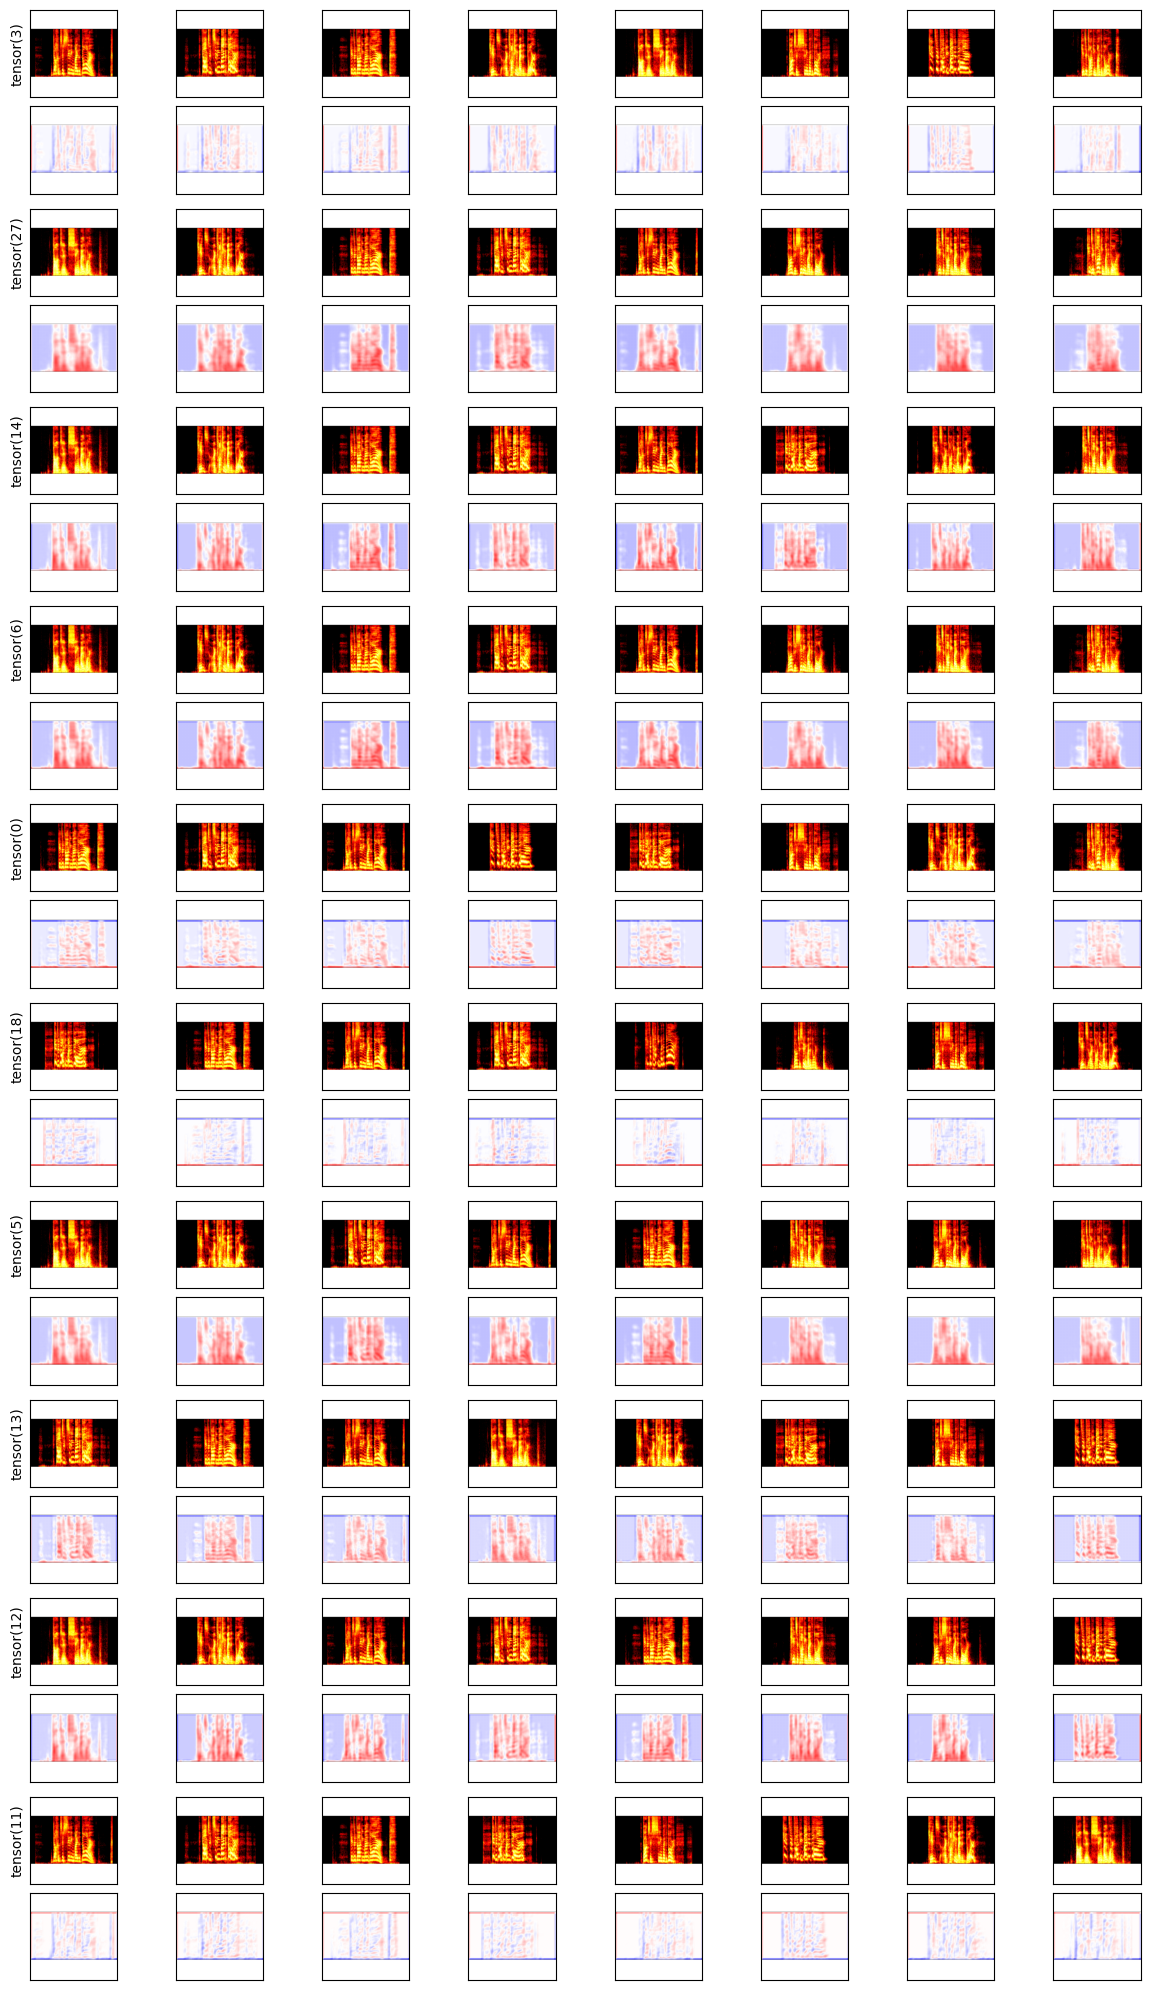

In [ ]:
plot_grid(ref_c, figsize=(12, 20))